# Intro

Notebook can train a model to generate sythetic data.   
Ensure the 'ds_suffix' matches the one used to generated the dataset (Under "Set input dataset" & in create_dataset notebook)  
Parameters for generating data (seq_len, number of seqs) are near bottom (Under "Generate Full dataset")

In [1]:
import logging
import os
import sys
import time
import datetime

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
import seaborn as sns

In [2]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

# SETUP DATA

### Set input dataset and nb_id

In [4]:
from my_lib.encoding import load_data_encoder

data_encoder = load_data_encoder()

vars_to_load =  ['CLOCK_DIMS', 'DATA_KEY_ORDER', 'LOSS_TYPES']


for var in vars_to_load:
    cmd = f'{var} = data_encoder.field_info["{var}"]'
    print(cmd)
    exec(cmd)

CLOCK_DIMS = data_encoder.field_info["CLOCK_DIMS"]
DATA_KEY_ORDER = data_encoder.field_info["DATA_KEY_ORDER"]
LOSS_TYPES = data_encoder.field_info["LOSS_TYPES"]


### Load training data

In [5]:
for data in ['inp_tensor', 'tar_tensor', 'inds']:
    for suffix in ["tr", "cv"]:
        file = f'{data}_{suffix}'
        cmd = f'{file} = np.load(f"stored_data/{file}.npy")'
        print(cmd)
        exec(cmd)


attributes = np.load(f"stored_data/attributes.npy")

inp_tensor_tr.shape, tar_tensor_tr.shape, attributes.shape

inp_tensor_tr = np.load(f"stored_data/inp_tensor_tr.npy")
inp_tensor_cv = np.load(f"stored_data/inp_tensor_cv.npy")
tar_tensor_tr = np.load(f"stored_data/tar_tensor_tr.npy")
tar_tensor_cv = np.load(f"stored_data/tar_tensor_cv.npy")
inds_tr = np.load(f"stored_data/inds_tr.npy")
inds_cv = np.load(f"stored_data/inds_cv.npy")


((11483, 81, 27), (11483, 80, 9), (14354,))

In [6]:
inp_tensor_cv.shape, tar_tensor_cv.shape

((2871, 81, 27), (2871, 80, 9))

In [7]:
_, n_steps, n_feat_inp = inp_tensor_tr.shape
n_feat_tar = tar_tensor_tr.shape[2]

### Create tf dataset

In [9]:
ds_tr = tf.data.Dataset.from_tensor_slices((inp_tensor_tr.astype(np.float32), tar_tensor_tr.astype(np.float32)))
ds_cv = tf.data.Dataset.from_tensor_slices((inp_tensor_cv.astype(np.float32), tar_tensor_cv.astype(np.float32)))

ds_tr

2022-04-13 20:08:17.066770: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<TensorSliceDataset element_spec=(TensorSpec(shape=(81, 27), dtype=tf.float32, name=None), TensorSpec(shape=(80, 9), dtype=tf.float32, name=None))>

In [10]:
from my_lib.transformer_core import make_batches

BUFFER_SIZE = ds_tr.cardinality().numpy()


# Training

## Loss

In [11]:
# float32, used for training 
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return  -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi)


In [12]:
# float64, used for generation 
def log_normal_pdf_gen(sample, mean, logvar, raxis=1):
    log2pi = tf.cast(tf.math.log(2. * np.pi), tf.float64)
    return  -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi)


In [13]:

from tensorflow.keras.losses import CategoricalCrossentropy, MeanSquaredError, SparseCategoricalCrossentropy


loss_scce_logit = SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

loss_scce_probit = SparseCategoricalCrossentropy(
    from_logits=False, reduction='none')

loss_mse = MeanSquaredError(reduction='none')



def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(tf.reduce_sum(seq, axis=2), 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)



def loss_function(real, pred):
    loss_parts = []
    loss_parts_weighted = []

    for k, k_pred in pred.items():
        
#         print(k, k_pred.shape)

        st = FIELD_STARTS_TAR[k]
        end = st + FIELD_DIMS_TAR[k]
        loss_type = LOSS_TYPES[k]
        

        if loss_type == "scce":
            loss_ = loss_scce_logit(real[:, :, st:end], k_pred)
        elif loss_type == "clock":
            loss_ = loss_scce_probit(real[:, :, st:end], clock_to_onehot(k, k_pred))
        elif loss_type == "mse":
            loss_ = loss_mse(real[:, :, st:end], k_pred)
        elif loss_type == "pdf":
            loss_ = -log_normal_pdf(real[:, :, st:end], k_pred[:,:,0:1], k_pred[:,:,1:2])[:,:,0]
        else:
            raise Exception(f"Invalid loss type! Got loss type = {loss_type} with key = {k}. Check field_config.py for loss types")
            

        mask = tf.math.logical_not(tf.math.equal(tf.reduce_sum(real, axis=2), 0))
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        loss_ = tf.reduce_sum(loss_)/tf.reduce_sum(mask) 

        loss_parts.append(loss_)
        loss_parts_weighted.append(loss_ * LOSS_WEIGHTS[k])

    return tf.reduce_sum(loss_parts_weighted), loss_parts




## Set Banksformer configs

In [14]:
# others are None
ACTIVATIONS = {
    "td_sc": "relu",
    "log_amount_sc": "relu"
}

In [15]:
# vars_to_load =  ['DATA_KEY_ORDER', 'CLOCK_DIMS', 'INP_ENCODINGS', 'TAR_ENCODINGS']
vars_to_load = ['FIELD_DIMS_IN', 'FIELD_STARTS_IN', 'FIELD_DIMS_TAR', 'FIELD_STARTS_TAR', 'FIELD_DIMS_NET', 'FIELD_STARTS_NET']

for var in vars_to_load:
    cmd = f'{var} = data_encoder.field_info["{var}"]'
    print(cmd)
    exec(cmd)

FIELD_DIMS_IN = data_encoder.field_info["FIELD_DIMS_IN"]
FIELD_STARTS_IN = data_encoder.field_info["FIELD_STARTS_IN"]
FIELD_DIMS_TAR = data_encoder.field_info["FIELD_DIMS_TAR"]
FIELD_STARTS_TAR = data_encoder.field_info["FIELD_STARTS_TAR"]
FIELD_DIMS_NET = data_encoder.field_info["FIELD_DIMS_NET"]
FIELD_STARTS_NET = data_encoder.field_info["FIELD_STARTS_NET"]


In [16]:
config = {}
# FIELD_DIMS_IN, FIELD_STARTS_IN, FIELD_DIMS_TAR, FIELD_STARTS_TAR, FIELD_DIMS_NET, FIELD_STARTS_NET = get_field_info(ds_suffix)

config["ORDER"] = DATA_KEY_ORDER
config["FIELD_STARTS_IN"] = FIELD_STARTS_IN
config["FIELD_DIMS_IN"] = FIELD_DIMS_IN
config["FIELD_STARTS_NET"] = FIELD_STARTS_NET
config["FIELD_DIMS_NET"] = FIELD_DIMS_NET


config["ACTIVATIONS"] = ACTIVATIONS



## Training Loop 

In [17]:
from my_lib.BanksformerGen import Transformer
import pickle 





all_models = []
for_df = []


def to_num(x):
    try: return int(x)
    except: return float(x)

def id_str_to_folder(id_str):
    return id_str.replace(".", "__")
beta = 1


# moredate
LOSS_WEIGHTS_OLD = {
 'td_sc':1.,
 'year': 0.5,
 'month': 0.15,
 'day': 0.25,
 'dow': 0.1,
 'tcode_num': 1.,
 'log_amount_sc': 2.}


LOSS_WEIGHTS_0 = {
 'td_sc':1.,
 'month': 0.015,
 'day': 0.025,
 'dow': 0.01,
 'tcode_num': 1.,
 'log_amount_sc': 2.}



LOSS_WEIGHTS_MID = {
 'td_sc':1.,
 'month': 0.07,
 'day': 0.1,
 'dow': 0.04,
 'tcode_num': 1.,
 'log_amount_sc': 2.}



lws = [(LOSS_WEIGHTS_0, "0"), (LOSS_WEIGHTS_OLD, "moredate")]

# lws = [(LOSS_WEIGHTS_MID, "mid")]

td_loss_fns = [(loss_mse, "loss_mse")]


EPOCHS = 80
EARLY_STOP = 2

num_layers_enc = None
dropout_rate = 0.1
dr = dropout_rate
opt_name = "adam"
# td_loss_fn = loss_mse


## Tuned these ! 
d_model = 128
num_layers_dec = 4
num_heads = 2
bs = 64
# lws # above


LOSS_WEIGHTS, lwi = lws[0]


### newer fields, copy loss weights from similar fields
LOSS_WEIGHTS["dtme"] = LOSS_WEIGHTS["day"]
LOSS_WEIGHTS["k_symbol_num"] = LOSS_WEIGHTS["tcode_num"]
LOSS_WEIGHTS["operation_num"] = LOSS_WEIGHTS["tcode_num"]
LOSS_WEIGHTS["type_num"] = LOSS_WEIGHTS["tcode_num"]


dff = d_model


# skip_next = True   
for i in range(3):

#     for num_layers_dec in [3]:
#         for d_model in [32, 128]:
#             for num_heads in [2,4]:
            
                # v

                start = time.time()


                print(datetime.datetime.now().strftime("%H:%M"))


                transformer = Transformer(
                    num_layers_enc=num_layers_enc, num_layers_dec=num_layers_dec,
                    d_model=d_model,
                    num_heads=num_heads,
                    dff=dff,
                    maximum_position_encoding=256,
                   net_info = None, 
                    inp_dim = n_feat_inp,
                    final_dim= None,
                    config=config,
                    rate=dr)

                optimizer = tf.keras.optimizers.Adam()
                transformer.optimizer =  optimizer


                train_batches = make_batches(ds_tr, BUFFER_SIZE, bs)


                transformer.loss_function = loss_function

                transformer.LOSS_WEIGHTS = LOSS_WEIGHTS

                id_str = f"v2b__nld_{num_layers_dec}-dm_{d_model}-nh_{num_heads}-i_{i}-dr_{dr}-opt_{opt_name}-lwi_{lwi}-bs_{bs}"

                print("Begin running", id_str)
                transformer.id_str = id_str


                all_models.append(transformer)
                transformer.compile()


                transformer.checkpoint_path = f"./checkpoints/{id_str_to_folder(transformer.id_str)}"
                transformer.ckpt = tf.train.Checkpoint(transformer=transformer,
                                           optimizer=optimizer)
                transformer.ckpt_manager = tf.train.CheckpointManager(transformer.ckpt, 
                                                                      transformer.checkpoint_path, max_to_keep=EARLY_STOP)

                
                
                ## If network already exists, load weights instead of training
                if transformer.ckpt_manager.latest_checkpoint:
                    transformer.ckpt.restore(transformer.ckpt_manager.latest_checkpoint)
                    print('Latest checkpoint restored!!')    
                    continue


                transformer.fit(train_batches, inp_tensor_cv, tar_tensor_cv, 
                                epochs= EPOCHS, early_stop=EARLY_STOP, print_every=50, ckpt_every = 1)

                transformer.fit_time = time.time() - start
                transformer.results["fit_time"] = transformer.fit_time 

                with open(f"training_history/{id_str_to_folder(transformer.id_str)}.pickle", "wb") as f:
                    pickle.dump(transformer.results, f) 
                    print("Wrote transformer.results to", f.name)


                for_df.append((num_layers_dec, d_model, num_heads, i, dr, beta, dff,
                               np.min(transformer.results["val_loss"]), opt_name, transformer.id_str))




20:09
Begin running v2b__nld_4-dm_128-nh_2-i_0-dr_0.1-opt_adam-lwi_0-bs_64
Epoch 1 Batch 0 Loss 14.9234
Epoch 1 Batch 50 Loss 11.9195
Epoch 1 Batch 100 Loss 11.2842
Epoch 1 Batch 150 Loss 10.9633
Epoch 1 Loss 10.4828
** on validation data loss is 7.5292
Not recording acc: 'Transformer' object has no attribute 'acc_function'
Time taken for 1 epoch: 161.98 secs

Saving checkpoint for epoch 1 at ./checkpoints/v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64/ckpt-1
Epoch 2 Batch 0 Loss 7.6099
Epoch 2 Batch 50 Loss 7.4858
Epoch 2 Batch 100 Loss 7.2283
Epoch 2 Batch 150 Loss 7.0586
Epoch 2 Loss 6.9592
** on validation data loss is 6.3389
Time taken for 1 epoch: 147.52 secs

Saving checkpoint for epoch 2 at ./checkpoints/v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64/ckpt-2
Epoch 3 Batch 0 Loss 6.4385
Epoch 3 Batch 50 Loss 6.3202
Epoch 3 Batch 100 Loss 6.2352
Epoch 3 Batch 150 Loss 6.1492
Epoch 3 Loss 6.0966
** on validation data loss is 5.8037
Time taken for 1 epoch: 150.32 s

### Results

In [18]:
df = pd.DataFrame.from_records(for_df, columns=['num_layers_dec', 'd_model', 'num_heads', 'i', "dr", "beta", "dff",
                                                "val loss", "opt name","id_str"]).sort_values("val loss")

In [19]:
with pd.option_context('display.max_colwidth', None, "display.max_rows", None, "display.max_columns", None):
    display(df.sort_values("val loss"))

,num_layers_dec,d_model,num_heads,i,dr,beta,dff,val loss,opt name,id_str
0,4,128,2,0,0.1,1,128,3.550501,adam,v2b__nld_4-dm_128-nh_2-i_0-dr_0.1-opt_adam-lwi_0-bs_64
2,4,128,2,2,0.1,1,128,3.630562,adam,v2b__nld_4-dm_128-nh_2-i_2-dr_0.1-opt_adam-lwi_0-bs_64
1,4,128,2,1,0.1,1,128,3.656870,adam,v2b__nld_4-dm_128-nh_2-i_1-dr_0.1-opt_adam-lwi_0-bs_64


In [20]:
try: # will fail if loaded weight and not trained
    
    bs = df.id_str.apply(lambda x: int(x.split("-")[-1].split("_")[-1]))
    lwi = df.id_str.apply(lambda x: x.split("-")[-2].split("_")[-1])
    

    df['bs'] = bs
    df['lwi'] = lwi
    


    with pd.option_context('display.max_colwidth', None, "display.max_rows", None, "display.max_columns", None):
        display(df.sort_values(["lwi", "val loss"]))
        
        
    times= [t.fit_time for t in all_models]
    df['times'] = times
    
    
except Exception as e:
    print("Failed with error:", e)

,num_layers_dec,d_model,num_heads,i,dr,beta,dff,val loss,opt name,id_str,bs,lwi
0,4,128,2,0,0.1,1,128,3.550501,adam,v2b__nld_4-dm_128-nh_2-i_0-dr_0.1-opt_adam-lwi_0-bs_64,64,0
2,4,128,2,2,0.1,1,128,3.630562,adam,v2b__nld_4-dm_128-nh_2-i_2-dr_0.1-opt_adam-lwi_0-bs_64,64,0
1,4,128,2,1,0.1,1,128,3.656870,adam,v2b__nld_4-dm_128-nh_2-i_1-dr_0.1-opt_adam-lwi_0-bs_64,64,0


In [21]:
transformer = all_models[0]

In [22]:
np.array(transformer.results["val_loss"])

array([7.529211 , 6.3388853, 5.803706 , 4.713489 , 4.2920885, 4.268908 ,
       3.9633422, 3.87718  , 3.8371792, 3.8153808, 3.7553988, 3.6720362,
       3.680633 , 3.6664991, 3.6511633, 3.6401076, 3.6226833, 3.6165934,
       3.6053796, 3.6089058, 3.5888238, 3.5830383, 3.575469 , 3.5710444,
       3.578946 , 3.5613787, 3.573672 , 3.5505006, 3.5668035, 3.5831795],
      dtype=float32)

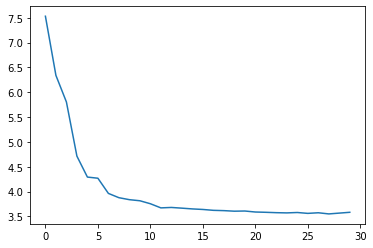

In [23]:
plt.plot(np.array(transformer.results["val_loss"]))

# Generate  
Warning: Code below is not nice and should be refactored

In [24]:
MAX_YEARS_SPAN = 15   # will throw an error if it tries to generate dates this far past data_encoder.START_DATE

## Set up

In [25]:
from my_lib.encoding import encode_time_value
#, decode_time_value

clocks = {}
for max_val in [7, 31, 12]:
    cmd = f"clocks[{max_val}] = np.array([encode_time_value(val, {max_val}) for val in range({max_val})])"
    print("Running", cmd)
    exec(cmd)
    
clocks.keys()

Running clocks[7] = np.array([encode_time_value(val, 7) for val in range(7)])
Running clocks[31] = np.array([encode_time_value(val, 31) for val in range(31)])
Running clocks[12] = np.array([encode_time_value(val, 12) for val in range(12)])


dict_keys([7, 31, 12])

In [26]:
# START_DATE = data_encoder.START_DATE 
START_DATE = str(data_encoder.START_DATE).split()[0]

import calendar
get_dtme = lambda d: calendar.monthrange(d.year, d.month)[1] - d.day

if type(START_DATE) == str:
    START_DATE = datetime.datetime.strptime(START_DATE, "%Y-%m-%d").date()
    
    

END_DATE = START_DATE.replace(year = START_DATE.year+ MAX_YEARS_SPAN)

ALL_DATES = [START_DATE + datetime.timedelta(i) for i in range((END_DATE - START_DATE).days)]


# Keep all date information in an array 
# when generating dates, I keep track of dates with an offset from data_encoder.START_DATE
# when generating a batch of dates can get the info as AD[offset_inds,:]
AD = np.array([(d.month % 12, d.day % 31, d.weekday() % 7, i, d.year, get_dtme(d)) for i, d in enumerate(ALL_DATES)])

AD[[0,3], :]

In [27]:
from my_lib.transformer_core import create_masks
from my_lib.encoding import bulk_encode_time_value
    
    
# This function is used when generating new samples
# it takes the raw predictions output by the layer 'net_name' which corrisponds to a data field.
# The predictions encode a probablity distribution, and here we sample the appropiate distribution
# and reencodes the samples to the appropriate input format.
def reencode_net_prediction(net_name, predictions):
    
    # print("reencode_net_prediction:", net_name, predictions.shape)
    
    continous_fields = ['td_sc', "log_amount_sc"]
    cat_fields = data_encoder.field_info["CAT_FIELDS"]
    date_fields = ['month', 'day', 'dtme', 'dow']
    
    batch_size = predictions.shape[0]
    

    # Continous values fields (bs, len, 2), first feature is mean, second is logvar for normal distribtion
    #    need to return shape (bs, len, 1) 
    if net_name in continous_fields:
        mean, log_var = predictions[:, :, 0:1],  predictions[:, :, 1:2]
        # sd = np.sqrt(np.exp(log_var))
        log_sd = log_var/2.
        return mean +  log_sd*np.random.normal(size=(batch_size, 1, 1)) 

    
    # Dates are represented as categorical distribution, 
    # and need to be reencoded with the clock encoding
    elif net_name in date_fields:
        dim = FIELD_DIMS_NET[net_name]
        choices = np.arange(dim)
        ps = tf.nn.softmax(predictions, axis=2).numpy().reshape(-1, dim)
        
        choosen =  np.array([np.random.choice(choices, p=p) for p in ps])

        x = bulk_encode_time_value(choosen, max_val=dim)
                
        return np.reshape(x, newshape=(batch_size, -1, 2))
        

    
    # Categorical variables are categorical distributions,
    # and need to be reencoded with one hot encoding
    elif net_name in cat_fields:
    # elif "_num" in net_name:
        dim = FIELD_DIMS_NET[net_name]
        choices = np.arange(dim)

        ps = tf.nn.softmax(predictions, axis=2).numpy().reshape(-1, dim)        
        choosen =  np.reshape([np.random.choice(choices, p=p) for p in ps], newshape=(batch_size, -1))

        return tf.one_hot(choosen, depth=dim)
    
    else:
        raise Exception(f"Got invalid net_name: {net_name}")

        
days_per_month = np.array([(datetime.date(1990, month, 1) - datetime.timedelta(1)).day for month in range(1,13)]) # 0 = dec


@np.vectorize
def get_short_name(tcode):
    return short_names[tcode]



# Decodes the raw tensor output from Banksformer to data frame with proper scaling and encoding 
def bulk_decode(seqs, start_dates, return_single_df=False, return_df_list=False):
    
    # *****
    ages = seqs[:, 0, :] * data_encoder.ATTR_SCALE
    seqs = seqs[:, 1:, :]
    assert np.sum(np.diff(ages)) == 0, f"Bad formating, expected all entries same in each row, got {ages}"

    
    amts = seqs[:, :, FIELD_STARTS_IN["log_amount_sc"]].numpy() * data_encoder.LOG_AMOUNT_SCALE
    amts = 10 ** amts
    amts = np.round(amts - 1.0, 2)


    days_passed = np.round(seqs[:, :, FIELD_STARTS_IN["td_sc"]] *data_encoder.TD_SCALE ).astype(int)
  

#     years = np.round(seqs[:, :, FIELD_STARTS["year"]]/ YEAR_SCALE).astype(int) + START_YEAR

    months = np.argmax(seqs[:, :, FIELD_STARTS_IN["month"]: FIELD_STARTS_IN["month"] + FIELD_DIMS_IN["month"]], axis=-1)
    
    
    days = np.argmax(seqs[:, :, FIELD_STARTS_IN["day"]: FIELD_STARTS_IN["day"] + FIELD_DIMS_IN["day"]], axis=-1)
    days[days==0] = days_per_month[months[days==0]]
    months[months==0] = 12 # needs to be done after days (above)
    # date_fields = get_date_str(months, days)
    
    dpc = np.cumsum(days_passed, axis=1) 
    dates = np.array([[start_dates[i] + datetime.timedelta(int(d)) for d in dpc[i]]for i in range(len(start_dates))])
    
    # numbers
    code_col_names = []
    code_vals = [] 
    
    # code names
    code_names = []
    code_names_cols = []
    for field, start_i in FIELD_STARTS_IN.items():
        if "_num" in field:
            code_col_names.append(field)
            code_vals.append(np.argmax(seqs[:, :, start_i: start_i + FIELD_DIMS_IN[field]], axis=-1))
            
            

    # add customer age to all transactions
    ages = np.repeat(ages[:, 0:1], amts.shape[1], axis=1).astype(int) 
    

    return_vals = amts, *code_vals, *code_names, days_passed, ages, dates
    return_lbls = "amount", *code_col_names, *code_names_cols, "days_passed", "age", "date"

    if return_df_list:
        return [add_code_names(pd.DataFrame.from_records(zip(*x), columns=return_lbls)) 
                    for x in zip(*return_vals)]
    
    if return_single_df:
        df = pd.DataFrame.from_records([x for x in zip(*[x.reshape(-1) for x in return_vals])], columns=return_lbls)
        return add_code_names(df)
    
    
    return return_vals



def add_code_names(df):
    for field in CAT_FIELDS:
        field = field.replace("_num", "")
        df[field] = df[field + "_num"].apply(lambda x: get_code_from_num(data_encoder, field, x))
    return df




# returns the number corrisponding to 'code', which is an option for 'field'
def get_code_num(data_encoder, field, code):
    field = field.replace("_num", "")
    d = data_encoder.__getattribute__(f"{field}_to_num".upper())
    return d[code]


# returns the code corrisponding to the number 'num', which is an option for 'field'
def get_code_from_num(data_encoder, field, num):
    field = field.replace("_num", "")
    d = data_encoder.__getattribute__(f"num_to_{field}".upper())
    return d[num]

CAT_FIELDS = data_encoder.field_info["CAT_FIELDS"]





In [28]:
def generate_seqs(length, ages, start_dates, greedy_dates = False, return_single_df=False, return_df_list=False):
    
    if return_single_df and return_df_list:
        raise Exception("At most one of: 'return_single_df' and 'return_df_list' can be true")
    
    date_inds = np.array([(d - START_DATE).days for d in start_dates])
    
    max_length = length

    output = np.repeat(np.array(ages)[:, None, None], repeats=n_feat_inp, axis=2) / data_encoder.ATTR_SCALE
    
    raw_preds = []
    raw_preds.append(output)

    date_info = None
    
    
    for i in range(max_length):


        combined_mask, dec_padding_mask = create_masks(output)

        
        enc_preds, attn, raw_ps, date_inds  = call_to_generate(transformer, output, 
                                                 True, 
                                                 combined_mask, 
                                                 dec_padding_mask, date_inds, date_info, greedy_dates =greedy_dates)

        
        raw_preds.append(raw_ps)

        enc_preds = tf.reshape(tf.constant(enc_preds), shape=(-1,1, n_feat_inp))

        output = tf.concat([output, enc_preds], axis=1)

        
    return bulk_decode(output, start_dates, return_single_df, return_df_list), output, raw_preds






## Forward pass through transformer
# 
# Returns: preds, attn_w, raw_preds, inds
# the returned preds have multiple timesteps, but we only 
# care about the last (it's the only new one)
def call_to_generate(transformer, tar, training,
           look_ahead_mask, dec_padding_mask, start_inds, prev_date_info=None, greedy_dates = False):
    

    ### Pass through decoder stack ###
    dec_output, attention_weights = transformer.decoder(
        tar, training, look_ahead_mask, dec_padding_mask)


    final_output = transformer.final_layer(dec_output) 

    
    
    ### Predict each field  ###
    preds = {}
    raw_preds = {}
    encoded_preds_d = {}
    


    for net_name in transformer.ORDER:  

        pred = transformer.__getattribute__(net_name)(final_output)
        raw_preds[net_name] = pred
        
        # print("pre reencode_net_prediction:", net_name, pred.shape)
        pred = reencode_net_prediction(net_name, pred) # keeps time step
        # print("post reencode_net_prediction:", net_name, pred.shape)

        encoded_preds_d[net_name] = pred[:,-1,:] 

        final_output = tf.concat([final_output, pred], axis=2)
            
    
    combined_date_info, inds = raw_dates_to_reencoded(raw_preds, start_inds)
    
    encoded_preds_d.update(combined_date_info)

    l = [encoded_preds_d[k] for k in transformer.ORDER]
    encoded_preds =  tf.expand_dims(tf.concat(l, axis=1), axis=1)
    
    

    return encoded_preds, attention_weights, raw_preds, start_inds + inds, 







In [29]:
PMF_EPS = 1e-6

# Takes raw predictions (info about predicted day, month, dow, and days passed) and start inds 
# (indicate the current date for each of the seqs) 
# Computes a number of days passed for each based on inputs (either greedily or with sampling)
# returns the new_dates (old_dates + days passed) and their indicies
def raw_dates_to_reencoded(raw, start_inds,  max_days = 100, greedy_decode=False):
    
    all_ps = [tf.nn.softmax(raw[k][:,-1]).numpy() for k in ["month", "day", "dow", "dtme"]]

    timesteps = np.zeros(len(start_inds)).astype(int)

    sc = data_encoder.TD_SCALE
    for i, (month_ps, day_ps, dow_ps, dtme_ps, td_pred, si) in enumerate(zip(*all_ps, raw["td_sc"][:,-1].numpy(), start_inds)):
        
        

        ps = month_ps[AD[si:si+max_days,0]]*day_ps[AD[si:si+max_days,1]]*dow_ps[AD[si:si+max_days,2]] *dtme_ps[AD[si:si+max_days,-1]] * \
                np.exp(log_normal_pdf_gen(AD[si:si+max_days,3]-si, mean = td_pred[0]*sc, logvar=td_pred[1]*sc))
#                 pmf(max(PMF_EPS, l_pred)*data_encoder.TD_SCALE, AD[si:si+max_days,3]-si ) 

        
        if greedy_decode:
            timesteps[i] = np.argmax(ps)
        else:
            timesteps[i] = np.random.choice(max_days, p=ps/sum(ps))
        
        
    inds = start_inds + timesteps
    
    
    return_ = {}
    return_["td_sc"] = tf.expand_dims(timesteps.astype(np.float32)/ data_encoder.TD_SCALE, axis=1)
    return_["month"] = bulk_encode_time_value(AD[inds, 0], 12)
    return_["day"] = bulk_encode_time_value(AD[inds, 1], 31)
    return_["dow"] = bulk_encode_time_value(AD[inds, 2], 7)
    return_["dtme"] = bulk_encode_time_value(AD[inds, -1], 31)
    
    

    return return_, timesteps


## Generate example

In [31]:
seqs_dfs, seqs, raw = generate_seqs(length= 25, 
                          ages=[75, 25], 
                          start_dates=[START_DATE, START_DATE+datetime.timedelta(days=1)], 
                          greedy_dates=False,
                          return_df_list=True)

In [32]:
df = seqs_dfs[1]
df

,amount,k_symbol_num,operation_num,type_num,days_passed,age,date,k_symbol,operation,type
0,1204.630005,0,3,1,1,25,1993-01-03,NaN,CASH WITHDRAWAL,DEBIT
1,1608.829956,3,4,1,5,25,1993-01-08,HOUSEHOLD,REMITTANCE TO ANOTHER BANK,DEBIT
2,3956.620117,0,0,0,3,25,1993-01-11,NaN,CREDIT IN CASH,CREDIT
3,1418.010010,0,3,1,0,25,1993-01-11,NaN,CASH WITHDRAWAL,DEBIT
4,1856.709961,0,0,0,0,25,1993-01-11,NaN,CREDIT IN CASH,CREDIT
5,27.730000,1,2,0,20,25,1993-01-31,INTEREST CREDITED,NaN,CREDIT
6,9.160000,2,3,1,0,25,1993-01-31,PAYMENT ON STATEMENT,CASH WITHDRAWAL,DEBIT
7,1005.950012,3,4,1,9,25,1993-02-09,HOUSEHOLD,REMITTANCE TO ANOTHER BANK,DEBIT
8,3604.959961,0,0,0,1,25,1993-02-10,NaN,CREDIT IN CASH,CREDIT
9,1582.949951,0,3,1,10,25,1993-02-20,NaN,CASH WITHDRAWAL,DEBIT


# Generate Full dataset

In [33]:
data_encoder.__dict__.keys()

dict_keys(['categorical_fields', 'START_DATE', 'LOG_AMOUNT_SCALE', 'TD_SCALE', 'ATTR_SCALE', 'K_SYMBOL_TO_NUM', 'NUM_TO_K_SYMBOL', 'n_k_symbols', 'OPERATION_TO_NUM', 'NUM_TO_OPERATION', 'n_operations', 'TYPE_TO_NUM', 'NUM_TO_TYPE', 'n_types', 'field_info'])

In [34]:
seq_len = 40
n_seqs_to_generate = 5000

In [35]:


real_df = pd.read_csv(f"stored_data/final_df.csv", parse_dates=["datetime"])
start_date_opts = real_df.groupby("account_id")["datetime"].min().dt.date.to_list()
# start_date_opts = [START_DATE + datetime.timedelta(i) for i in range(365)]


start_dates = np.random.choice(start_date_opts, size=n_seqs_to_generate)


seq_ages = np.random.choice(attributes, size=n_seqs_to_generate)
seq_ages

array([33., 77., 61., ..., 59., 77., 43.])

In [36]:
for i in range(len(all_models)):
    
    
    
    transformer = all_models[i]
    
    print("Begin with ", transformer.id_str)
    
    save_as = f"generated_data/sqrt-log_var__gen_{id_str_to_folder(transformer.id_str)}-len_{seq_len}-v2.csv"
    
    if os.path.exists(save_as):
        print("**** Skipping because file already exists. File name =", save_as, "\n\n\n")

    start = time.time()
    full_df, seqs, raw = generate_seqs(length= seq_len, 
                                       ages=seq_ages, 
                                       start_dates= start_dates, 
                                       return_single_df=True,
                                      greedy_dates=True)
    
    full_df["account_id"] = np.arange(len(full_df)) // seq_len
    

    print(f"took {time.time() - start} secs to generate")


    full_df.to_csv(save_as)
    print("Wrote df to", save_as)

Begin with  v2b__nld_4-dm_128-nh_2-i_0-dr_0.1-opt_adam-lwi_0-bs_64
took 1061.0861518383026 secs to generate
Wrote df to generated_data/sqrt-log_var__gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64-len_40-v2.csv
Begin with  v2b__nld_4-dm_128-nh_2-i_1-dr_0.1-opt_adam-lwi_0-bs_64
took 1084.5057411193848 secs to generate
Wrote df to generated_data/sqrt-log_var__gen_v2b__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64-len_40-v2.csv
Begin with  v2b__nld_4-dm_128-nh_2-i_2-dr_0.1-opt_adam-lwi_0-bs_64
took 1144.5846037864685 secs to generate
Wrote df to generated_data/sqrt-log_var__gen_v2b__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64-len_40-v2.csv
